# Age recognition

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-анализ-данных" data-toc-modified-id="Загрузка-и-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и анализ данных</a></span></li><li><span><a href="#Построение-модели" data-toc-modified-id="Построение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Построение модели</a></span></li><li><span><a href="#Анализ-модели:" data-toc-modified-id="Анализ-модели:-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><strong>Анализ модели:</strong></a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

Условный ритейлер внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Построим модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Загрузка и анализ данных

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [3]:
path_local = 'datasets/faces_project/gt_train.csv'
path_csv = 0
path_train = 0
if os.path.exists(path_local):
    path_сsv = path_local
    path_train = 'datasets/faces_project/gt_train.csv'
else:
    path_csv = '/datasets/faces/labels.csv'
    path_train = '/datasets/faces/final_files/'

In [4]:
train_labels = pd.read_csv(path_csv)
train_labels    

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


Text(0.5, 1.0, 'Возраст')

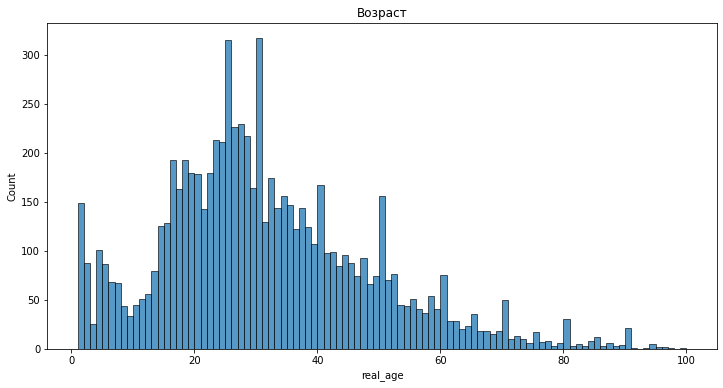

In [4]:
plt.figure(figsize = (12, 6))
sns.histplot(train_labels['real_age'], binwidth=1).set_title('Возраст')

**Вывод:** 
* Наибольшее количество фотографий в датасете - люди в возрасте 18-40 лет. Также часто встрачаются фотографии детей 1-2 года.
* Можно заметить пики в возрастах 25-30-40-50-60-70-80-90 лет. Думаю это связано с округлениями при разметке

In [5]:
# Используем ImageDataGenerator как инструмент для доступа к потоку фотографий
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=train_labels,
        directory=path_train,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

features, target = next(datagen_flow)

Found 7591 validated image filenames.


Выведем фотографии с которыми будет работать наша модель.

Это хорошая практика, помогает увидеть изображения, с которыми будет работать наша модель, заметить какие-то детали и особенности, улучшить понимание задачи и получить определенную интуицию. А также заранее оценить подходящие для наших данных методы аугментации

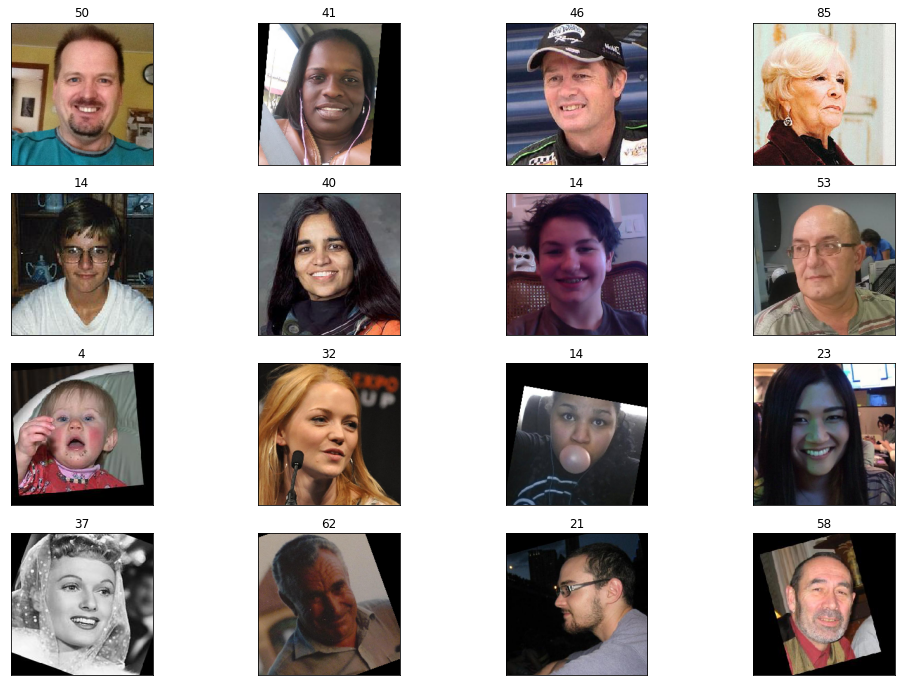

In [13]:
fig = plt.figure(figsize=(17,12))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i])

**Вывод по EDA:**

Датасет скошен, длинный хвост наблюдается из объектов старше 60 лет. Почти на всех круглых датах наблюдаются пики. Возможно это либо ошибка ассесора, либо ошибка при сборе данных. Может сказаться на качестве модели. Фото людей старше 90 можно исключить из датасета


В датасете представлены фотографии различных людей различных возрастных групп. У фотографий различается качество, есть черно-белые, есть цветные фотографии, некоторые фотографии уже повернуты - аугментация здесь не потребуется. Есть фотографии как в анфас, так и в профиль. Есть фото с аксесуарами и головными уборами.

## Построение модели 

Используем предобученную модель и c помощью finetuning и transfer-learning обучим нейронку определять возраст покупателей.
Напишем функции для создания датагенераторов, а также создания и обучения модели.  
Для обучающего генератора стоит использовать аугментацию, хотябы отражение по горизонтали.  В качестве лосс-функция выберем mse.  
Шаг обучения подберем в процессе.

*Обучение произdодилось с использованием облачных мощностей Yandex.  
Поэтому ниже приведен только код функций и скопирован результат их работы на платформе.*

In [7]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0003)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

        model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

Train for 356 steps, validate for 119 steps
Epoch 1/15
2022-08-28 16:39:47.032141: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-28 16:39:47.451781: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 80s - loss: 202.3351 - mae: 10.5518 - val_loss: 288.0104 - val_mae: 12.8136
Epoch 2/15
356/356 - 57s - loss: 98.6499 - mae: 7.5533 - val_loss: 167.7774 - val_mae: 10.0983
Epoch 3/15
356/356 - 54s - loss: 60.3209 - mae: 5.9972 - val_loss: 93.6138 - val_mae: 7.2480
Epoch 4/15
356/356 - 53s - loss: 38.9192 - mae: 4.8416 - val_loss: 115.5339 - val_mae: 8.1988
Epoch 5/15
356/356 - 51s - loss: 27.5639 - mae: 4.0108 - val_loss: 89.4460 - val_mae: 7.1031
Epoch 6/15
356/356 - 39s - loss: 19.3834 - mae: 3.3779 - val_loss: 81.1926 - val_mae: 6.9624
Epoch 7/15
356/356 - 38s - loss: 14.9939 - mae: 2.9851 - val_loss: 116.4563 - val_mae: 8.3694
Epoch 8/15
356/356 - 38s - loss: 12.9072 - mae: 2.7560 - val_loss: 77.5636 - val_mae: 6.7220
Epoch 9/15
356/356 - 38s - loss: 13.4956 - mae: 2.8136 - val_loss: 70.8683 - val_mae: 6.4427
Epoch 10/15
356/356 - 39s - loss: 14.0081 - mae: 2.8453 - val_loss: 130.6543 - val_mae: 9.1255
Epoch 11/15
356/356 - 39s - loss: 15.3017 - mae: 2.9882 - val_loss: 83.2325 - val_mae: 7.0934
Epoch 12/15
356/356 - 38s - loss: 16.5871 - mae: 3.0950 - val_loss: 97.1145 - val_mae: 7.2896
Epoch 13/15
356/356 - 38s - loss: 18.1028 - mae: 3.2875 - val_loss: 102.9976 - val_mae: 8.0563
Epoch 14/15
356/356 - 39s - loss: 15.7516 - mae: 3.0225 - val_loss: 105.5640 - val_mae: 7.3637
Epoch 15/15
356/356 - 38s - loss: 12.8866 - mae: 2.7252 - val_loss: 98.7715 - val_mae: 7.1366
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 98.7715 - mae: 7.1366
Test MAE: 7.1366

Модель обучена и преодолела планку требуемой точности

## **Анализ модели:**  
* Модель обучилась на 15 эпохах, за основу взята архитектура ResNet50 с предобученными на ImageNet весами.
* Веса бэкбон не замораживались - в датасете достаточно фотографий.
* В качестве последнего использовался слой с функцией активации ReLU.
* Оптимизировались по MSE с применением алгоритма Adam.
* Даже для небольшого количества эпох можно заметить переобучение - значительное увеличение качества на обучающей выборке, при этом незначительное улучшение на валидационной.



## Общий вывод 
MAE для нашей модели получилась около 7 лет.  
Для решения первой задачи в целом это подходит.  
Дальше можно было бы доделать отнесение покупателей к определенной возрасной категории и предлагать уже тавары, характерные для этой категории. Либо в целом изменить задачу на классификацию. Хотя думаю и по результатам регрессии категории определятся довольно хорошо (или это по сути вообще одно и то же? Определить регрессией возраст и отнести к категории). 

Для решения же задачи контроля возраста для продажи алкоголя, 7 лет видится довольно большой погрешностью. В такой ситуации  можно сделать некую сигнализацию для всех людей, возраст которых был определен моделью как <= 25 лет. 